# Music Therapy Investigation

The purpose of this analysis is to discover trends in music therapy which might help improve the practice. Particularly of interest is the preferred genre of music of patients, and how it relates to the success of the treatment. If a clear trend could be established, this could help enhance music therapy practice for others in the future. A few other relationships can be explored as well, such as the effect of the average BPM of their favorite genre on the success of their treatment, and the frequency with which they listen to various genres.

## Null and Alternative Hypotheses

**Null Hypothesis**: The success of music therapy treatment does not depend on the musical selection or any other musical factors.

**Alternative Hypothesis**: Choice of musical genre does have an impact on the success of music therapy treatment.

In [18]:
# Import necessary libraries

import pandas as pd
import numpy as np

# Visualization libraries

import matplotlib.pyplot as plt
import seaborn as sns

# Statistics libraries

import statsmodels as sum
from scipy.stats import f_oneway 

# Machine Learning libraries

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

In [2]:
# Import cleaned data

survey_df = pd.read_csv('../data/interim/clean_survey_results.csv')
survey_df.head()

,Age,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,BPM,Frequency [Classical],...,Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects
0,18,4.0,No,No,No,Video game music,No,Yes,132.0,Never,...,Rarely,Never,Rarely,Rarely,Very frequently,7,7,10,2,No effect
1,61,2.5,Yes,No,Yes,Jazz,Yes,Yes,84.0,Sometimes,...,Sometimes,Sometimes,Never,Never,Never,9,7,3,3,Improve
2,18,4.0,Yes,No,No,R&B,Yes,No,107.0,Never,...,Sometimes,Very frequently,Very frequently,Never,Rarely,7,2,5,9,Improve
3,18,5.0,Yes,Yes,Yes,Jazz,Yes,Yes,86.0,Rarely,...,Very frequently,Very frequently,Very frequently,Very frequently,Never,8,8,7,7,Improve
4,18,3.0,Yes,Yes,No,Video game music,Yes,Yes,66.0,Sometimes,...,Rarely,Rarely,Never,Never,Sometimes,4,8,6,0,Improve


# Exploring BPM

Being one of the few continuous variables in this dataset, understanding this column could help develop effective predictive models. Its relationship with genre is particularly of interest. If there is a relationship between BPM and genre, then it can be effective in predicting Music effects.

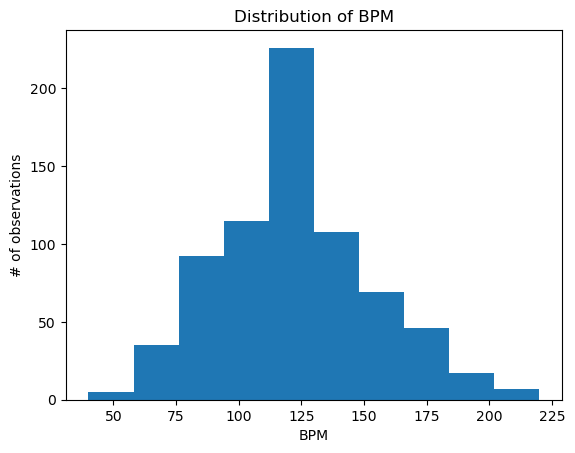

In [3]:
# Visualize overall distribution of BPM

plt.hist(survey_df['BPM'])
plt.xlabel('BPM')
plt.ylabel('# of observations')
plt.title('Distribution of BPM')

plt.show()

BPM appears to be normally distributed across the dataset. Let's see how it's distributed grouped by genre.

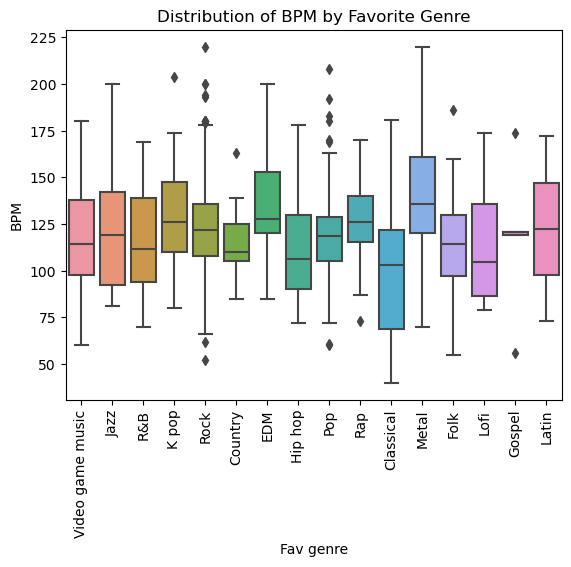

In [4]:
# Visualize distribution of BPM by genre

sns.boxplot(x='Fav genre', y='BPM', data=survey_df)

plt.xticks(rotation=90)
plt.title('Distribution of BPM by Favorite Genre')

plt.show()

This figure reveals that the median BPM of each genre does lie somewhere between 100 and 130. Some genres, such as Classical, have a much wider IQR, implying that data is less clustered around the median and more dispersed. Some genres have highly right-skewed BPM, such as Lofi and Jazz. 

The figure also reveals that very few respondents selected Gospel as their favorite genre.

We'll use an ANOVA test to test whether statistically significant differences exist in BPM between genres.

### ANOVA Test

Null hypothesis: There is no significant difference in mean BPM per genre.

Alternative hypothesis: At least one genre has a significantly different mean BPM from the other groups.

In [5]:
# Separate data by genre
genres = survey_df['Fav genre'].unique()
bpm_groups = [survey_df[survey_df['Fav genre'] == genre]['BPM'] for genre in genres]

# Perform one-way ANOVA
f_stat, p_value = f_oneway(*bpm_groups)

print(f"F-statistic: {f_stat}, p-value: {p_value}")

F-statistic: 4.9092158286651095, p-value: 3.384358972161804e-09


The p-value represents the probability that a large difference in mean BPM was observed purely by chance between genres. Since this is very low, this means we can reject the null hypothesis and conclude that there is a statistically significant difference between mean BPM.

The f-statistic is relatively large, implying that there is more variation between genre mean BPMs rather than within each genre.

## Logistic Regression



In [6]:
# Load preprocessed data

ml_survey_data = pd.read_csv('../data/processed/pre_processed_survey_results.csv')
ml_survey_data.head()

,Age,Hours per day,While working,Instrumentalist,Composer,Exploratory,Foreign languages,BPM,Frequency [Classical],Frequency [Country],...,Jazz,K pop,Latin,Lofi,Metal,Pop,R&B,Rap,Rock,Video game music
0,18,4.0,0,0,0,0,1,132.0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,61,2.5,1,0,1,1,1,84.0,2,0,...,1,0,0,0,0,0,0,0,0,0
2,18,4.0,1,0,0,1,0,107.0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,18,5.0,1,1,1,1,1,86.0,1,2,...,1,0,0,0,0,0,0,0,0,0
4,18,3.0,1,1,0,1,1,66.0,2,0,...,0,0,0,0,0,0,0,0,0,1


In [25]:
# Separate data in dependent and explanatory variables

X = ml_survey_data['BPM'].values.reshape(-1,1)
y = ml_survey_data['Rock'].values

# Create training and testing data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=True)

# Initialize logistic regression instance
lr = LogisticRegression()

lr.fit(X_train, y_train)
predictions = lr.predict(X_test)

In [26]:
prediction_probs = lr.predict_proba(X_test)[:,1]
prediction_probs

array([0.26944405, 0.29184038, 0.27494042, 0.26267193, 0.28378391,
       0.27494042, 0.27218355, 0.31032479, 0.26808084, 0.27355982,
       0.27540158, 0.28661201, 0.27586322, 0.25469143, 0.26311997,
       0.27035528, 0.27035528, 0.25999396, 0.28144008, 0.26536758,
       0.29857505, 0.27310058, 0.27235763, 0.29809105, 0.27443702,
       0.28661201, 0.27443702, 0.28331421, 0.30884219, 0.26581857,
       0.29809105, 0.27586322, 0.26944405, 0.25910525, 0.27494042,
       0.30051555, 0.29136276, 0.26717447, 0.26672202, 0.26311997,
       0.2823762 , 0.2617773 , 0.27264182, 0.27586322, 0.26808084,
       0.27494042, 0.25689214, 0.24601345, 0.26717447, 0.27310058,
       0.27235763, 0.27910807, 0.28755845, 0.27586322, 0.27494042,
       0.28144008, 0.277251  , 0.26133073, 0.26808084, 0.28566744,
       0.27494042, 0.28661201, 0.28190791, 0.28898159, 0.31729489,
       0.26133073, 0.28425409, 0.292797  , 0.28425409, 0.30343975,
       0.2823762 , 0.28425409, 0.27401954, 0.25910525, 0.26808

In [16]:
print(accuracy_score(y_test, predictions))

0.7407407407407407


In [12]:
print(confusion_matrix(y_test, predictions))

[[160   0]
 [ 56   0]]


In [23]:
print(roc_auc_score(y_test, prediction_probs))

0.5291294642857144
